In [1]:
#imports
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

In [2]:
#load in data
rates_df = pd.read_csv("data/daily-treasury-rates.csv")
rates_df.head()

,Date,1 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
0,09/20/2024,4.87,4.88,4.75,4.70,4.43,3.92,3.55,3.46,3.48,3.59,3.73,4.10,4.07
1,09/19/2024,4.89,4.91,4.80,4.73,4.46,3.93,3.59,3.47,3.49,3.60,3.73,4.11,4.06
2,09/18/2024,4.91,4.91,4.84,4.76,4.50,3.95,3.61,3.49,3.47,3.58,3.70,4.08,4.03
3,09/17/2024,5.05,5.05,4.95,4.87,4.55,3.99,3.59,3.45,3.44,3.53,3.65,4.02,3.96
4,09/16/2024,5.11,5.10,4.96,4.88,4.55,3.96,3.56,3.42,3.41,3.51,3.63,4.01,3.94


In [3]:
#remove date column for ease
rates_df_no_date = rates_df.drop("Date", axis = 1)
rates_df_no_date.head(5)

,1 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
0,4.87,4.88,4.75,4.70,4.43,3.92,3.55,3.46,3.48,3.59,3.73,4.10,4.07
1,4.89,4.91,4.80,4.73,4.46,3.93,3.59,3.47,3.49,3.60,3.73,4.11,4.06
2,4.91,4.91,4.84,4.76,4.50,3.95,3.61,3.49,3.47,3.58,3.70,4.08,4.03
3,5.05,5.05,4.95,4.87,4.55,3.99,3.59,3.45,3.44,3.53,3.65,4.02,3.96
4,5.11,5.10,4.96,4.88,4.55,3.96,3.56,3.42,3.41,3.51,3.63,4.01,3.94


In [4]:
#grab the cross section we want
rates_cross_section = pd.DataFrame(rates_df_no_date.iloc[0])
rates_cross_section.reset_index(inplace = True)
rates_cross_section.columns = ['MaturityLabel', 'Yield']
rates_cross_section

,MaturityLabel,Yield
0,1 Mo,4.87
1,2 Mo,4.88
2,3 Mo,4.75
3,4 Mo,4.70
4,6 Mo,4.43
5,1 Yr,3.92
6,2 Yr,3.55
7,3 Yr,3.46
8,5 Yr,3.48
9,7 Yr,3.59


In [5]:
rates_cross_section['Yield'] = rates_cross_section['Yield'].astype(float)

In [6]:
rates_cross_section['Maturity'] = rates_cross_section['MaturityLabel'].apply(
    lambda x: float(re.match(r'(\d+)', x).group(1)) / 12.0 if 'Mo' in x else
              float(re.match(r'(\d+)', x).group(1)) if 'Yr' in x else np.nan
)
rates_cross_section = rates_cross_section.sort_values('Maturity').reset_index(drop=True)
rates_cross_section

,MaturityLabel,Yield,Maturity
0,1 Mo,4.87,0.083333
1,2 Mo,4.88,0.166667
2,3 Mo,4.75,0.250000
3,4 Mo,4.70,0.333333
4,6 Mo,4.43,0.500000
5,1 Yr,3.92,1.000000
6,2 Yr,3.55,2.000000
7,3 Yr,3.46,3.000000
8,5 Yr,3.48,5.000000
9,7 Yr,3.59,7.000000


In [7]:
lambda_est = 1.0

# Lambda functions for the basis functions
term1_lambda = lambda tau, lambda_: (1 - np.exp(-tau / lambda_)) / (tau / lambda_)
term2_lambda = lambda tau, lambda_: term1_lambda(tau, lambda_) - np.exp(-tau / lambda_)

In [8]:
rates_cross_section['Slope'] = rates_cross_section['Maturity'].apply(lambda tau: term1_lambda(tau, lambda_est))
rates_cross_section['Curvature'] = rates_cross_section['Maturity'].apply(lambda tau: term2_lambda(tau, lambda_est))
rates_cross_section

,MaturityLabel,Yield,Maturity,Slope,Curvature
0,1 Mo,4.87,0.083333,0.959467,0.039423
1,2 Mo,4.88,0.166667,0.921110,0.074628
2,3 Mo,4.75,0.250000,0.884797,0.105996
3,4 Mo,4.70,0.333333,0.850406,0.133875
4,6 Mo,4.43,0.500000,0.786939,0.180408
5,1 Yr,3.92,1.000000,0.632121,0.264241
6,2 Yr,3.55,2.000000,0.432332,0.296997
7,3 Yr,3.46,3.000000,0.316738,0.266951
8,5 Yr,3.48,5.000000,0.198652,0.191914
9,7 Yr,3.59,7.000000,0.142727,0.141815


In [9]:
X = rates_cross_section[['Slope', 'Curvature']].values
X = np.column_stack((np.ones(len(X)), X))

yields = rates_cross_section['Yield'].values

In [10]:
corr_matrix = np.corrcoef(X[:, 1:].T)
print("Correlation Matrix:")
print(corr_matrix)

Correlation Matrix:
[[ 1.         -0.01010181]
 [-0.01010181  1.        ]]


In [11]:
ols_reg = LinearRegression(fit_intercept=False)
ols_reg.fit(X, yields)
beta_ols = ols_reg.coef_

print("OLS Estimated Parameters:")
print(f"beta_0: {beta_ols[0]:.4f}")
print(f"beta_1: {beta_ols[1]:.4f}")
print(f"beta_2: {beta_ols[2]:.4f}")

OLS Estimated Parameters:
beta_0: 4.0530
beta_1: 1.1853
beta_2: -3.5314


In [12]:
yields_pred = ols_reg.predict(X)
mse = np.mean((yields - yields_pred) ** 2)
print(f"Mean Squared Error: {mse:.6f}")

Mean Squared Error: 0.010386


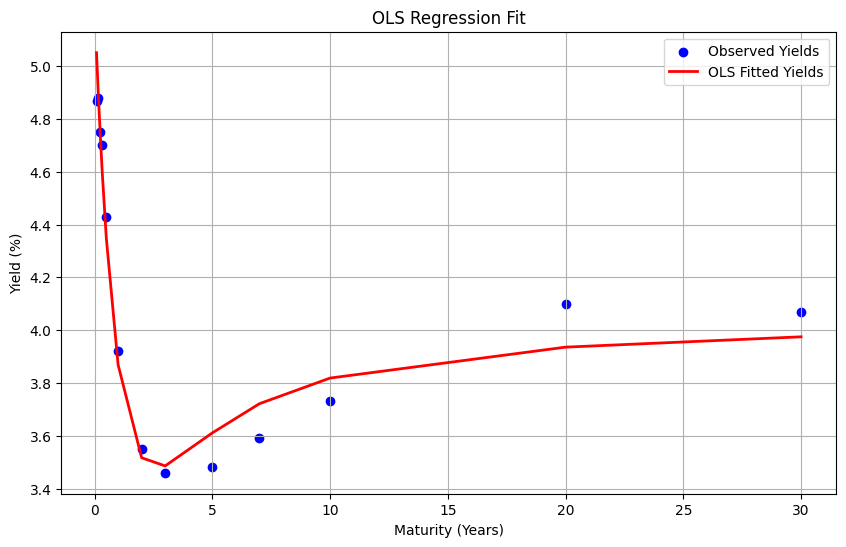

In [13]:
tau = rates_cross_section['Maturity']
plt.figure(figsize=(10, 6))
plt.scatter(tau, yields, color='blue', label='Observed Yields')
plt.plot(tau, yields_pred, color='red', label='OLS Fitted Yields', linewidth=2)
plt.title('OLS Regression Fit')
plt.xlabel('Maturity (Years)')
plt.ylabel('Yield (%)')
plt.legend()
plt.grid(True)
plt.show()